# Importação das Bibliotecas

In [2]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 81 kB 8.0 MB/s 
     |████████████████████████████████| 210 kB 55.0 MB/s 
     |████████████████████████████████| 78 kB 5.8 MB/s 
     |████████████████████████████████| 150 kB 66.9 MB/s 
     |████████████████████████████████| 113 kB 71.5 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=edd0e3f63ee302b8535efcbbf1a6d231eeb29a1dbabc08139f77fabf7bcd31fa
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
!pip install imbalanced-learn

In [4]:
import pandas as pd
import numpy as np
import random
from collections import Counter

#Processing
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import LabelEncoder

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

#Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import TruncatedSVD

#Otimização
import optuna

#Plot
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
random.seed(42)

# Inicialização dos Datasets

In [7]:
noStem_df = pd.read_csv('/content/drive/MyDrive/ProjetoFinal_ProcessText/datasets/NoStem_TotalStopwordRemoval_dataset.csv')
noStem_df = noStem_df.dropna()
noStem_df

,sent_rating,processed_text_NoStopwords,data
0,negativo,som realmente entanto conectividade resposta m...,2021-06-09 00:00:00
1,negativo,produto responde corretamente comandos preciso...,2020-11-26 00:00:00
2,negativo,compra caixa som pensa normalmente leva-la Ale...,2021-01-05 00:00:00
3,negativo,funcionalidade Comprei lâmpadas smart plugs co...,2021-06-16 00:00:00
4,positivo,Excelente assistente som limpo Alexa dificulda...,2020-12-10 00:00:00
...,...,...,...
3805,positivo,mídia carregada Gostei comprei impulso arrepen...,2021-07-06 00:00:00
3806,positivo,dia comprei echo dot preta cabo tomada veio br...,2021-05-04 00:00:00
3807,positivo,Amei Alexa incrível fiquei chateada descobri f...,2021-05-18 00:00:00
3808,positivo,Atendeu expectativas Reconhece voz entende per...,2021-01-09 00:00:00


In [8]:
Stem_df = pd.read_csv('/content/drive/MyDrive/ProjetoFinal_ProcessText/datasets/Stem_TotalStopwordRemoval_dataset.csv')
Stem_df = Stem_df.dropna()
Stem_df

,sent_rating,processed_text_stem_NoStopwords,data
0,negativo,som realment entanto conectividad resposta mic...,2021-06-09 00:00:00
1,negativo,produto respond corretament comando preciso mé...,2020-11-26 00:00:00
2,negativo,compra caixa som pensa normalment leva-la alex...,2021-01-05 00:00:00
3,negativo,funcionalidad comprei lâmpada smart plug contr...,2021-06-16 00:00:00
4,positivo,excelent assistent som limpo alexa dificuldad ...,2020-12-10 00:00:00
...,...,...,...
3805,positivo,mídia carregada gostei comprei impulso arrepen...,2021-07-06 00:00:00
3806,positivo,dia comprei echo dot preta cabo tomada veio br...,2021-05-04 00:00:00
3807,positivo,amei alexa incrível fiquei chateada descobri f...,2021-05-18 00:00:00
3808,positivo,atendeu expectativa reconhec voz entend perfei...,2021-01-09 00:00:00


In [9]:
Stem_df['sent_rating'].value_counts()

positivo    3235
negativo     573
Name: sent_rating, dtype: int64

# Pipeline sem Stemming

In [10]:
X = noStem_df['processed_text_NoStopwords']
y = noStem_df['sent_rating']

## Label encoding de Y

In [11]:
y = LabelEncoder().fit_transform(y)
y

array([0, 0, 0, ..., 1, 1, 0])

## Vetorização por TFIDF

In [12]:
vectorizer_tfidf = TfidfVectorizer(ngram_range = (1,3))
tfidf_transformer = vectorizer_tfidf.fit(X)
X_tfidf = tfidf_transformer.transform(X)

In [13]:
X_tfidf.shape

(3808, 110439)

### Visuzalização por Truncated SVD

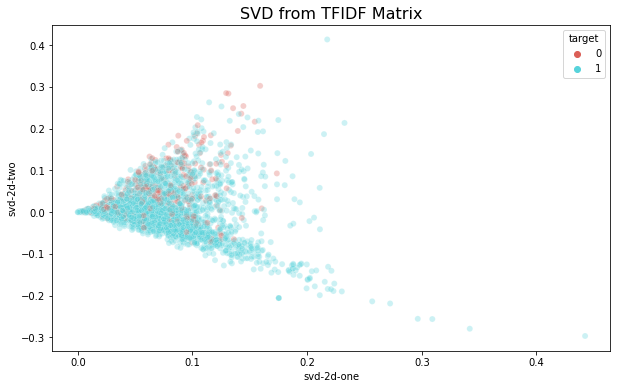

In [14]:
svd_df = pd.DataFrame(columns=['svd-2d-one','svd-2d-two','target'])

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

svd_df['svd-2d-one'] = X_reduced[:,0]
svd_df['svd-2d-two'] = X_reduced[:,1]
svd_df['target'] = y

title = 'SVD from TFIDF Matrix'
plt.figure(figsize=(10,6))
figure = sns.scatterplot(
    x="svd-2d-one", y="svd-2d-two",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=svd_df,
    legend="full",
    alpha=0.3
  )
plt.title(label=title,fontdict={'fontsize': 16})
plt.show()

## Seleção de atributos por Chi2

In [15]:
X_chi2 = SelectKBest(chi2, k=1000).fit_transform(X_tfidf, y)

### Remoção de atributos com correlação perfeita

In [16]:
correlated_features = set()
correlation_matrix = np.corrcoef(X_chi2.T.toarray())
correlation_matrix = pd.DataFrame(correlation_matrix)
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) == 1:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(len(correlated_features), 'atributos removidos')

343 atributos removidos


In [17]:
unique_features = set(range(0,1000)) - correlated_features

In [18]:
X_chi2 = X_chi2.tocsr()[:,list(unique_features)]

In [19]:
X_chi2.shape

(3808, 657)

#### Visuzalização por Truncated SVD

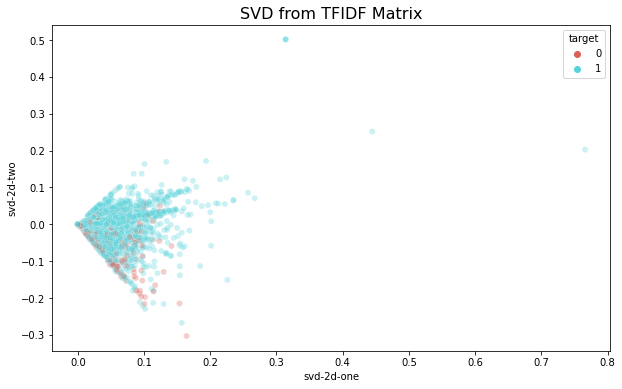

In [20]:
svd_chi_df = pd.DataFrame(columns=['svd-2d-one','svd-2d-two','target'])

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X_reduced = svd.fit_transform(X_chi2)

svd_chi_df['svd-2d-one'] = X_reduced[:,0]
svd_chi_df['svd-2d-two'] = X_reduced[:,1]
svd_chi_df['target'] = y

title = 'SVD from TFIDF Matrix'
plt.figure(figsize=(10,6))
figure = sns.scatterplot(
    x="svd-2d-one", y="svd-2d-two",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=svd_chi_df,
    legend="full",
    alpha=0.3
  )
plt.title(label=title,fontdict={'fontsize': 16})
plt.show()

## Divisão em treino/validação e teste

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_chi2, y, test_size=0.2, random_state=42)

## Balanceando a classe minoritária por SMOTE

In [22]:
oversample = SMOTE(sampling_strategy=0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [23]:
print(X_train.shape)
print(Counter(y_train))

(3871, 657)
Counter({1: 2581, 0: 1290})


#### Visuzalização por Truncated SVD

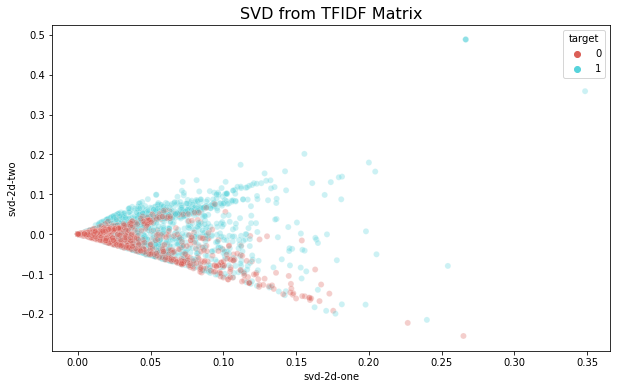

In [24]:
svd_chi_df = pd.DataFrame(columns=['svd-2d-one','svd-2d-two','target'])

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X_reduced = svd.fit_transform(X_train)

svd_chi_df['svd-2d-one'] = X_reduced[:,0]
svd_chi_df['svd-2d-two'] = X_reduced[:,1]
svd_chi_df['target'] = y_train

title = 'SVD from TFIDF Matrix'
plt.figure(figsize=(10,6))
figure = sns.scatterplot(
    x="svd-2d-one", y="svd-2d-two",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=svd_chi_df,
    legend="full",
    alpha=0.3
  )
plt.title(label=title,fontdict={'fontsize': 16})
plt.show()

## Treino e validação dos modelos

### Dummy

O dummy classifier será avaliado primeiro para que haja uma noção do que é o desempenho base para este dataset desbalanceado 

In [25]:
dummy = DummyClassifier()
scores = ['f1','precision','recall']
dummy_results_cv = cross_validate(dummy, X_train, y_train, cv=10,scoring=scores)

In [26]:
for metric in dummy_results_cv:
  print(f'Média de {metric}: {dummy_results_cv[metric].mean()}')

Média de fit_time: 0.001048898696899414
Média de score_time: 0.0030238866806030274
Média de test_f1: 0.800061823802164
Média de test_precision: 0.6667525773195877
Média de test_recall: 1.0


### Random Forest

#### Baseline

In [27]:
rf = RandomForestClassifier(random_state=42,n_jobs=-1)
scores = ['f1','precision','recall']
rf_results_cv = cross_validate(rf, X_train, y_train, cv=10,scoring=scores)

In [28]:
for metric in rf_results_cv:
  print(f'Média de {metric}: {rf_results_cv[metric].mean()}')

Média de fit_time: 1.0408606290817262
Média de score_time: 0.10497291088104248
Média de test_f1: 0.9387120145269918
Média de test_precision: 0.9128800913018994
Média de test_recall: 0.9678369399299633


#### Otimização

In [29]:

def objective(trial):

    classifier_name = trial.suggest_categorical("classifier", ["RandomForest"])

    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    #max_depth = trial.suggest_int("max_depth", 10, 100)
    criterion = trial.suggest_categorical("criterion", ['gini','entropy'])
    max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt','log2'])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    n_estimators = trial.suggest_int("n_estimators", 100, 2000)

    classifier_obj = RandomForestClassifier(
        bootstrap=bootstrap, max_depth=None,
        criterion=criterion, max_features=max_features,
        min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
        n_estimators=n_estimators, random_state=42, n_jobs=-1
    )

    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1, cv=5,scoring='f1')
    accuracy = score.mean()
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)
    print(study.best_trial)

[I 2022-04-02 18:47:51,245] A new study created in memory with name: no-name-5143b0ae-8a0a-43b6-9e01-d781b5c39cc0
[I 2022-04-02 18:48:24,154] Trial 0 finished with value: 0.8999470454842953 and parameters: {'classifier': 'RandomForest', 'bootstrap': False, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1033}. Best is trial 0 with value: 0.8999470454842953.
[I 2022-04-02 18:49:15,942] Trial 1 finished with value: 0.8895712944802776 and parameters: {'classifier': 'RandomForest', 'bootstrap': False, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1754}. Best is trial 0 with value: 0.8999470454842953.
[I 2022-04-02 18:49:36,679] Trial 2 finished with value: 0.8878322194108819 and parameters: {'classifier': 'RandomForest', 'bootstrap': True, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 889}. Best is t

FrozenTrial(number=35, values=[0.9463184687721571], datetime_start=datetime.datetime(2022, 4, 2, 19, 12, 15, 861402), datetime_complete=datetime.datetime(2022, 4, 2, 19, 13, 28, 457690), params={'classifier': 'RandomForest', 'bootstrap': False, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 1739}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'bootstrap': CategoricalDistribution(choices=(True, False)), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2')), 'min_samples_leaf': IntUniformDistribution(high=4, low=1, step=1), 'min_samples_split': IntUniformDistribution(high=10, low=2, step=1), 'n_estimators': IntUniformDistribution(high=2000, low=100, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=35, state=TrialState.COMPLETE, value=None)


### Repetição do treino para os parâmetros tunados

In [30]:
best_params={'bootstrap': False, 
             'criterion': 'gini', 
             'max_features': 'log2', 
             'min_samples_leaf': 1, 
             'min_samples_split': 7, 
             'n_estimators': 1739}

best_rf = RandomForestClassifier(**best_params)
scores = ['f1','precision','recall']
best_rf_results_cv = cross_validate(best_rf, X_train, y_train, cv=10,scoring=scores)
for metric in best_rf_results_cv:
  print(f'Média de {metric}: {best_rf_results_cv[metric].mean()}')

Média de fit_time: 21.616614246368407
Média de score_time: 0.5782042741775513
Média de test_f1: 0.9471736354943117
Média de test_precision: 0.92721184300188
Média de test_recall: 0.9690012271407621


## Teste do modelo

In [31]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

print('Precisão:',precision_score(y_test,y_pred))
print('Revocação:',recall_score(y_test,y_pred))
print('F1-score:',f1_score(y_test,y_pred))

Precisão: 0.9042857142857142
Revocação: 0.9678899082568807
F1-score: 0.9350073855243722


## Salvando as predições junto ao dataframe original

In [32]:
_, predict_df, _, _ = train_test_split(noStem_df, y, test_size=0.2, random_state=42)
predict_df.insert(1, 'predict', y_pred)
predict_df.to_csv('/content/drive/MyDrive/ProjetoFinal_ProcessText/predict_datasets/RF_noStem_predict.csv')

# Pipeline com Stemming

In [33]:
X = Stem_df['processed_text_stem_NoStopwords']
y = Stem_df['sent_rating']

## Label encoding de Y

In [34]:
y = LabelEncoder().fit_transform(y)
y

array([0, 0, 0, ..., 1, 1, 0])

## Vetorização por TFIDF

In [35]:
vectorizer_tfidf = TfidfVectorizer(ngram_range = (1,3))
tfidf_transformer = vectorizer_tfidf.fit(X)
X_tfidf = tfidf_transformer.transform(X)

In [36]:
X_tfidf.shape

(3808, 108252)

### Visuzalização por Truncated SVD

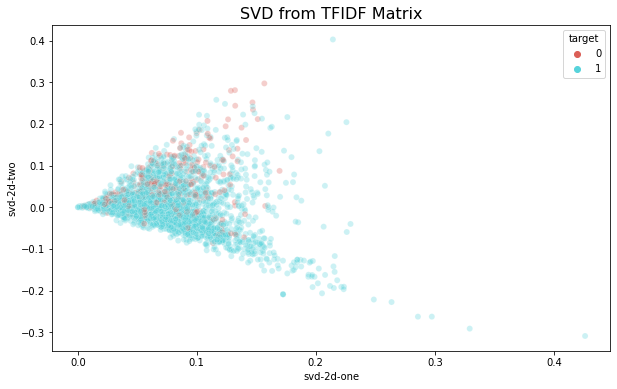

In [37]:
svd_df = pd.DataFrame(columns=['svd-2d-one','svd-2d-two','target'])

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

svd_df['svd-2d-one'] = X_reduced[:,0]
svd_df['svd-2d-two'] = X_reduced[:,1]
svd_df['target'] = y

title = 'SVD from TFIDF Matrix'
plt.figure(figsize=(10,6))
figure = sns.scatterplot(
    x="svd-2d-one", y="svd-2d-two",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=svd_df,
    legend="full",
    alpha=0.3
  )
plt.title(label=title,fontdict={'fontsize': 16})
plt.show()

## Seleção de atributos por Chi2

In [38]:
X_chi2 = SelectKBest(chi2, k=1000).fit_transform(X_tfidf, y)

### Remoção de atributos com correlação perfeita

In [39]:
correlated_features = set()
correlation_matrix = np.corrcoef(X_chi2.T.toarray())
correlation_matrix = pd.DataFrame(correlation_matrix)
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) == 1:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(len(correlated_features), 'atributos removidos')

353 atributos removidos


In [40]:
unique_features = set(range(0,1000)) - correlated_features

In [41]:
X_chi2 = X_chi2.tocsr()[:,list(unique_features)]

In [42]:
X_chi2.shape

(3808, 647)

#### Visuzalização por Truncated SVD

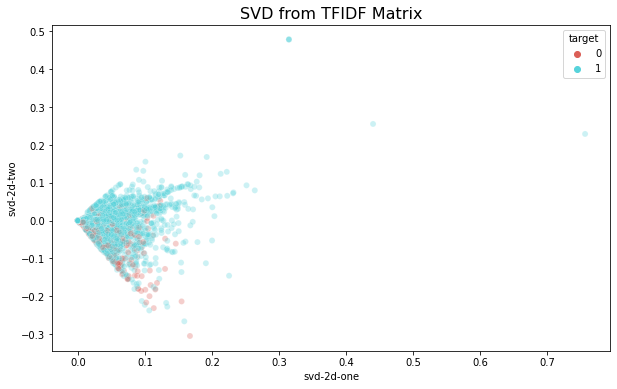

In [43]:
svd_chi_df = pd.DataFrame(columns=['svd-2d-one','svd-2d-two','target'])

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X_reduced = svd.fit_transform(X_chi2)

svd_chi_df['svd-2d-one'] = X_reduced[:,0]
svd_chi_df['svd-2d-two'] = X_reduced[:,1]
svd_chi_df['target'] = y

title = 'SVD from TFIDF Matrix'
plt.figure(figsize=(10,6))
figure = sns.scatterplot(
    x="svd-2d-one", y="svd-2d-two",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=svd_chi_df,
    legend="full",
    alpha=0.3
  )
plt.title(label=title,fontdict={'fontsize': 16})
plt.show()

# Divisão em treino/validação e teste

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_chi2, y, test_size=0.2, random_state=42)

# Balanceando a classe negativa por SMOTE

In [45]:
oversample = SMOTE(sampling_strategy=0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [46]:
print(X_train.shape)
print(Counter(y_train))

(3871, 647)
Counter({1: 2581, 0: 1290})


#### Visualização por Truncated SVD

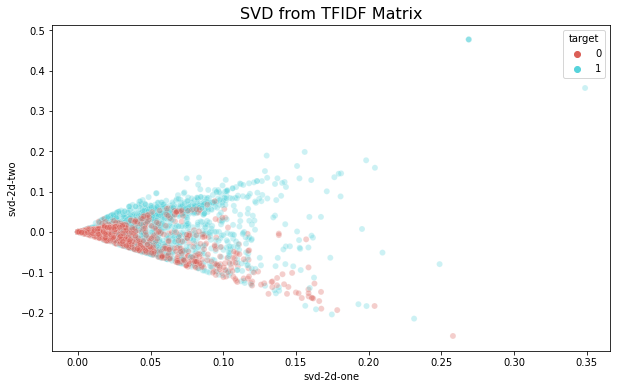

In [47]:
svd_chi_df = pd.DataFrame(columns=['svd-2d-one','svd-2d-two','target'])

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X_reduced = svd.fit_transform(X_train)

svd_chi_df['svd-2d-one'] = X_reduced[:,0]
svd_chi_df['svd-2d-two'] = X_reduced[:,1]
svd_chi_df['target'] = y_train

title = 'SVD from TFIDF Matrix'
plt.figure(figsize=(10,6))
figure = sns.scatterplot(
    x="svd-2d-one", y="svd-2d-two",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=svd_chi_df,
    legend="full",
    alpha=0.3
  )
plt.title(label=title,fontdict={'fontsize': 16})
plt.show()

## Treino e validação dos modelos

### Dummy

O dummy classifier será avaliado primeiro para que haja uma noção do que é o desempenho base para este dataset desbalanceado 

In [48]:
dummy = DummyClassifier()
scores = ['f1','precision','recall']
dummy_results_cv = cross_validate(dummy, X_train, y_train, cv=10,scoring=scores)

In [49]:
for metric in dummy_results_cv:
  print(f'Média de {metric}: {dummy_results_cv[metric].mean()}')

Média de fit_time: 0.001127767562866211
Média de score_time: 0.003225564956665039
Média de test_f1: 0.800061823802164
Média de test_precision: 0.6667525773195877
Média de test_recall: 1.0


### Random Forest

#### Baseline

In [50]:
rf = RandomForestClassifier()
scores = ['f1','precision','recall']
rf_results_cv = cross_validate(rf, X_train, y_train, cv=10,scoring=scores)

In [51]:
for metric in rf_results_cv:
  print(f'Média de {metric}: {rf_results_cv[metric].mean()}')

Média de fit_time: 1.0423906803131104
Média de score_time: 0.03150937557220459
Média de test_f1: 0.9414003261888493
Média de test_precision: 0.9191687226222742
Média de test_recall: 0.9662955314118105


#### Otimização

In [52]:

def objective(trial):

    classifier_name = trial.suggest_categorical("classifier", ["RandomForest"])

    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    #max_depth = trial.suggest_int("max_depth", 10, 100)
    criterion = trial.suggest_categorical("criterion", ['gini','entropy'])
    max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt','log2'])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    n_estimators = trial.suggest_int("n_estimators", 100, 2000)

    classifier_obj = RandomForestClassifier(
        bootstrap=bootstrap, max_depth=None,
        criterion=criterion, max_features=max_features,
        min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
        n_estimators=n_estimators
    )

    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1, cv=5,scoring='f1')
    accuracy = score.mean()
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)
    print(study.best_trial)

[I 2022-04-02 19:31:55,444] A new study created in memory with name: no-name-215d8b44-cf23-4f3e-b02e-2e683e4ce45e
[I 2022-04-02 19:32:16,291] Trial 0 finished with value: 0.8324294659722234 and parameters: {'classifier': 'RandomForest', 'bootstrap': True, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1688}. Best is trial 0 with value: 0.8324294659722234.
[I 2022-04-02 19:32:22,964] Trial 1 finished with value: 0.832210057044316 and parameters: {'classifier': 'RandomForest', 'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 613}. Best is trial 0 with value: 0.8324294659722234.
[I 2022-04-02 19:32:30,867] Trial 2 finished with value: 0.8954827172021662 and parameters: {'classifier': 'RandomForest', 'bootstrap': False, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 410}. Best is trial 2 wi

FrozenTrial(number=40, values=[0.9504792034327446], datetime_start=datetime.datetime(2022, 4, 2, 19, 57, 59, 274217), datetime_complete=datetime.datetime(2022, 4, 2, 19, 59, 19, 993763), params={'classifier': 'RandomForest', 'bootstrap': False, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1869}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'bootstrap': CategoricalDistribution(choices=(True, False)), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2')), 'min_samples_leaf': IntUniformDistribution(high=4, low=1, step=1), 'min_samples_split': IntUniformDistribution(high=10, low=2, step=1), 'n_estimators': IntUniformDistribution(high=2000, low=100, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=40, state=TrialState.COMPLETE, value=None)


### Repetição do treino para os parâmetros otimizados

In [53]:
best_params={'bootstrap': False, 
             'criterion': 'gini', 
             'max_features': 'log2', 
             'min_samples_leaf': 1, 
             'min_samples_split': 2, 
             'n_estimators': 1869}

best_rf = RandomForestClassifier(**best_params)
scores = ['f1','precision','recall']
best_rf_results_cv = cross_validate(best_rf, X_train, y_train, cv=10,scoring=scores)
for metric in best_rf_results_cv:
  print(f'Média de {metric}: {best_rf_results_cv[metric].mean()}')

Média de fit_time: 21.96349968910217
Média de score_time: 0.5844879865646362
Média de test_f1: 0.9526595254319478
Média de test_precision: 0.934522347245341
Média de test_recall: 0.9724910957469095


## Teste do modelo

In [54]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

print('Precisão:',precision_score(y_test,y_pred))
print('Revocação:',recall_score(y_test,y_pred))
print('F1-score:',f1_score(y_test,y_pred))

Precisão: 0.8884239888423989
Revocação: 0.9740061162079511
F1-score: 0.9292487235594457


## Salvando as predições junto ao dataframe original

In [55]:
_, predict_df, _, _ = train_test_split(Stem_df, y, test_size=0.2, random_state=42)
predict_df.insert(1, 'predict', y_pred)
predict_df.to_csv('/content/drive/MyDrive/ProjetoFinal_ProcessText/predict_datasets/RF_Stem_predict.csv')